In [4]:
import os
import sys
print(sys.version)

from astropy import units as u
from astropy.io import fits
import ccdproc as ccd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

3.6.1 |Anaconda custom (x86_64)| (default, Mar 22 2017, 19:25:17) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [5]:
rawdir = os.path.expanduser('~/SuPrimeCam/SuPrimeCam_S15A-UH33A/Raw')

In [6]:
file0 = 'SUPA01530620.fits'
files = ['{}{:d}.fits'.format(file0[0:11], n) for n in range(0,10)]
imageobjs = [fits.open(os.path.join(rawdir, file), 'readonly') for file in files]
imageobjs

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1132030f0>],

In [7]:
for header in headers:
    assert header.get('OBJECT') == headers[0].get('OBJECT')

In [105]:
# Subtract Overscan Regions and Assemble Chip Image
images = imageobjs
chips = {}
for i,image in enumerate(images):
    rawdata = image[0].data
    hdr = image[0].header

    # X Pixel Ranges of Amplifiers
    startx = [(1, hdr.get('S_EFMN11')),
              (2, hdr.get('S_EFMN21')),
              (3, hdr.get('S_EFMN31')),
              (4, hdr.get('S_EFMN41')),
             ]
    ordered_ch = np.array(sorted(startx, key=lambda x: x[1]))[:,0]
    
#     xflip = {'T': True, 'F': False}[hdr.get('S_XFLIP')]
#     yflip = {'T': True, 'F': False}[hdr.get('S_YFLIP')]

    ny = hdr.get('S_EFMX12') - hdr.get('S_EFMN12')
    nx = (hdr.get('S_EFMX41') - hdr.get('S_EFMN41') + hdr.get('S_EFMX31') - hdr.get('S_EFMN31') + 
          hdr.get('S_EFMX21') - hdr.get('S_EFMN21') + hdr.get('S_EFMX11') - hdr.get('S_EFMN11'))
    chips[i] = np.zeros((ny, nx))

    amps = {}
    for a,ch in enumerate(ordered_ch):
        osx = ccd.CCDData(data=rawdata[:,hdr.get(f'S_OSMN{ch:d}1'):hdr.get(f'S_OSMX{ch:d}1')],
                          uncertainty=None,
                          mask=None,
                          unit=u.adu)
        amps[ch] = ccd.CCDData(data=rawdata[:,hdr.get(f'S_EFMN{ch:d}1'):hdr.get(f'S_EFMX{ch:d}1')],
                               uncertainty=None,
                               mask=None,
                               unit=u.adu)
        amps[ch] = ccd.subtract_overscan(amps[ch], osx)

        osy = ccd.CCDData(data=rawdata[hdr.get(f'S_OSMN{ch:d}2'):hdr.get(f'S_OSMX{ch:d}2'),
                                       hdr.get('S_EFMN21'):hdr.get('S_EFMX21')],
                          uncertainty=None,
                          mask=None,
                          unit=u.adu)
        amps[ch] = amps[ch][hdr.get(f'S_EFMN{ch:d}2'):hdr.get(f'S_EFMX{ch:d}2'),:]
        amps[ch] = ccd.subtract_overscan(amps[ch], osy, overscan_axis=0)
        
        xpix1 = sum([amps[j].shape[1] for j in ordered_ch[0:a]])
        xpix2 = sum([amps[j].shape[1] for j in ordered_ch[0:a+1]])
        chips[i][:,xpix1:xpix2] = amps[ch].data

print(chips.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


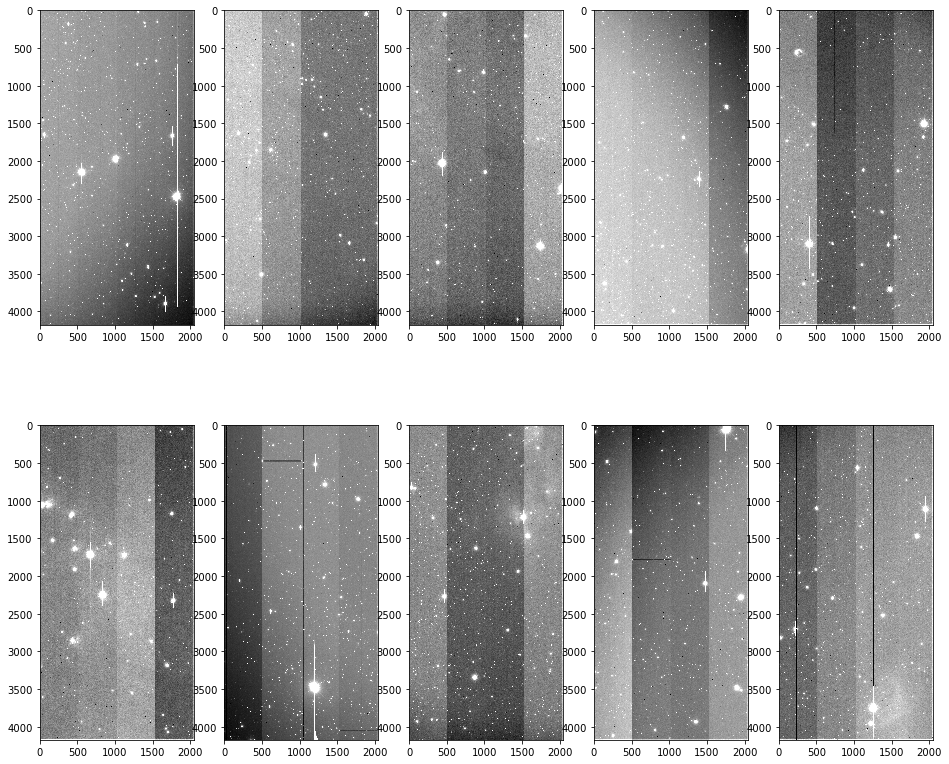

In [106]:
plt.figure(figsize=(16,14))

for chip in chips.keys():
    plt.subplot(2,5,chip+1)
    vmin = np.percentile(chips[chip], 0.75)
    vmax = np.percentile(chips[chip], 98.5)
    plt.imshow(chips[chip], vmin=vmin-100, vmax=vmax)

plt.show()